In [95]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import numpy as np

In [2]:
df = pd.read_excel('http://dataevents.hu/202303/filedataevents/competition_table.xlsx', engine='openpyxl')

In [3]:
df.head()

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag
0,0,2008-2009,div0,1.73,3.5,5.00,5,3,7,8,...,3.825,11.00,7.665,6.377,5.908,0.500,3.0,0,0,1
1,1,2008-2009,div0,1.25,5.5,12.00,7,0,2,5,...,3.582,2.10,2.250,2.833,2.475,0.333,0.0,0,1,0
2,2,2008-2009,div0,1.57,3.8,5.75,9,1,4,4,...,3.525,6.75,4.275,3.883,3.638,0.750,1.5,1,0,0
3,3,2008-2009,div0,1.17,7.0,15.00,11,2,6,7,...,3.975,4.20,2.750,2.333,2.550,0.600,0.0,1,0,0
4,4,2008-2009,div0,1.17,7.0,15.00,14,2,4,7,...,3.925,3.10,2.175,2.050,2.015,0.833,0.0,1,0,0


In [102]:
df[df.odds_home_team_win == 0]

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag,probable_event,home_win,home_win_actual,home_win_predicted,prob_home_win
15918,16035,2012-2013,div2,0.0,3.40,3.40,45,1,1,2,...,0.818,0.273,1,0,0,odds_home_team_win,0,0,1,inf
17020,17137,2012-2013,div4,0.0,3.60,3.25,28,1,1,2,...,0.909,0.273,1,0,0,odds_home_team_win,0,0,1,inf
24468,24587,2014-2015,div3,0.0,5.25,10.00,39,4,5,6,...,0.737,0.000,0,0,1,odds_home_team_win,0,0,1,inf
40652,40793,2018-2019,div2,0.0,3.75,4.20,29,4,7,8,...,1.143,0.214,1,0,0,odds_home_team_win,0,0,1,inf
41407,41550,2018-2019,div3,0.0,3.80,4.75,33,3,4,5,...,1.267,0.400,0,1,0,odds_home_team_win,0,0,1,inf
44220,44363,2018-2019,div14,0.0,3.50,4.50,23,3,5,6,...,0.200,0.900,0,0,1,odds_home_team_win,0,0,1,inf
44558,44701,2018-2019,div16,0.0,3.80,1.80,27,0,2,5,...,2.143,2.357,1,0,0,odds_home_team_win,0,0,1,inf


In [4]:
df.shape

(64166, 167)

In [49]:
df.season.value_counts()

2021-2022    6534
2020-2021    6368
2018-2019    5917
2017-2018    5730
2019-2020    5670
2013-2014    3848
2014-2015    3847
2015-2016    3845
2012-2013    3843
2010-2011    3842
2008-2009    3818
2009-2010    3799
2011-2012    3767
2016-2017    3338
Name: season, dtype: int64

In [5]:
df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win', 'home_win_flag', 'draw_flag', 'away_win_flag']].head(20)

,odds_home_team_win,odds_draw,odds_away_team_win,home_win_flag,draw_flag,away_win_flag
0,1.73,3.50,5.00,0,0,1
1,1.25,5.50,12.00,0,1,0
2,1.57,3.80,5.75,1,0,0
3,1.17,7.00,15.00,1,0,0
4,1.17,7.00,15.00,1,0,0
5,1.62,3.80,5.50,1,0,0
6,1.44,4.00,8.00,1,0,0
7,1.25,5.50,12.00,0,0,1
8,1.33,5.00,9.00,1,0,0
9,1.14,7.50,17.00,1,0,0


In [52]:
df['probable_event'] = df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win']].idxmin(axis = 1)

In [93]:
df['prob_home_win'] = 1 / df.odds_home_team_win

### Analyzing Home Wins

In [53]:
df['home_win_predicted'] = df.probable_event == 'odds_home_team_win'

In [54]:
df.home_win_predicted = df.home_win_predicted.astype('int')

In [55]:
df[['odds_home_team_win', 'odds_draw', 'odds_away_team_win', 'home_win_flag', 'draw_flag', 'away_win_flag', 'home_win_predicted']]

,odds_home_team_win,odds_draw,odds_away_team_win,home_win_flag,draw_flag,away_win_flag,home_win_predicted
0,1.73,3.50,5.00,0,0,1,1
1,1.25,5.50,12.00,0,1,0,1
2,1.57,3.80,5.75,1,0,0,1
3,1.17,7.00,15.00,1,0,0,1
4,1.17,7.00,15.00,1,0,0,1
...,...,...,...,...,...,...,...
64161,3.80,3.71,1.90,0,0,1,0
64162,3.62,3.42,2.04,0,0,1,0
64163,5.51,4.06,1.59,0,0,1,0
64164,3.83,3.76,1.87,0,0,1,0


In [56]:
tn, fp, fn, tp = confusion_matrix(df.home_win_flag, df.home_win_predicted).ravel()

In [84]:
pd.pivot_table(df, values='draw_flag', index=['home_win_predicted'],
                    columns=['home_win_flag'], aggfunc='count').applymap("{:,.0f}".format)

home_win_flag,0,1
home_win_predicted,,
0,"13,392","4,725"
1,"22,559","23,490"


In [91]:
23490 / (23490 + 22559)

0.510108797150861

In [64]:
pd.DataFrame(confusion_matrix(df.home_win_flag, df.home_win_predicted))

,0,1
0,13392,22559
1,4725,23490


In [61]:
print(tn, fp, fn, tp)

13392 22559 4725 23490


In [68]:
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = 1- TNR
FNR = 1 - TPR

In [71]:
print('TPR:', TPR)
print('TNR:', TNR)
print('FPR:', FPR)
print('FNR:', FNR)
print('Accuracy:', (tp + tn)/df.shape[0])

TPR: 0.8325358851674641
TNR: 0.3725070234485828
FPR: 0.6274929765514172
FNR: 0.16746411483253587
Accuracy: 0.5747903874325967


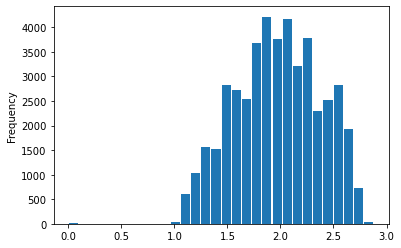

In [88]:
df[df.home_win_predicted == 1]['odds_home_team_win'].plot(kind = 'hist', bins = 30, rwidth = 0.9);

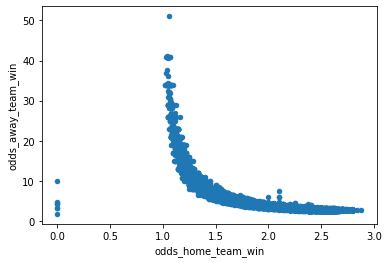

In [89]:
df[df.home_win_predicted == 1].plot(kind = 'scatter', x = 'odds_home_team_win', y = 'odds_away_team_win');

#### Strong Home Win Conviction

In [90]:
pd.pivot_table(df[df.odds_home_team_win < 2], values='draw_flag', index=['home_win_predicted'],
                    columns=['home_win_flag'], aggfunc='count').applymap("{:,.0f}".format)

home_win_flag,0,1
home_win_predicted,,
1,"8,683","13,707"


In [92]:
13707 / (13707 + 8683)

0.6121929432782492

In [97]:
prob_true, prob_pred = calibration_curve(df.home_win_flag, df.prob_home_win, n_bins=20, normalize = True)

C:\Users\duronelly2p331\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\calibration.py:859: RuntimeWarning: invalid value encountered in true_divide
  y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())


In [98]:
prob_true

array([0.43970448, 0.57142857])

In [99]:
prob_pred

array([ 0., nan])

In [100]:
df.prob_home_win.min()

0.034530386740331494

In [101]:
df.prob_home_win.max()

inf